# Base the lineair regression example on:

https://www.tensorflow.org/tutorials/keras/regression

In [1]:
import keras
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow import keras
from plotnine import *

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

mtcars = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
mtcars.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [208]:
mtcars.to_csv('mtcars.csv', index=False)

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: scatterplot.png


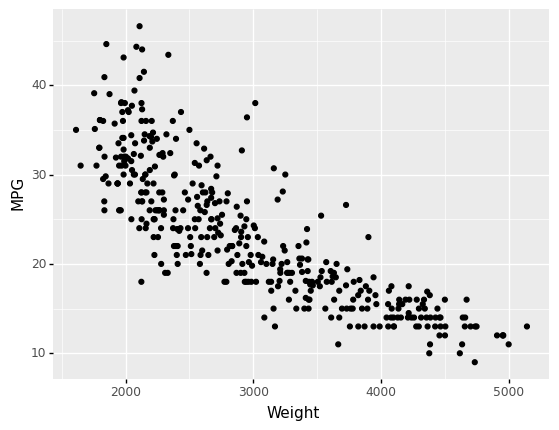

<ggplot: (8784263003176)>

In [153]:
gg = (
    ggplot(mtcars) + geom_point(aes(x='Weight', y='MPG'))
)
ggsave(gg, 'scatterplot.png', dpi=200)
gg

# Normalize data
This is needed, Keras becomes very unstable without it. 

In [3]:
from tensorflow.keras.layers import Normalization

# This needs to be added in front, or the solution will be very unstable
normalizer = Normalization(input_shape=[1,], axis=None)
normalizer.adapt(mtcars['Weight'])

mtcars['Weight_norm'] = np.array(normalizer(mtcars['Weight'])).flatten()

2022-03-20 08:55:37.764836: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(mtcars, test_size=0.1)
train_data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Weight_norm
331,33.8,4,97.0,67.0,2145.0,18.0,80,3,-0.975936
20,25.0,4,110.0,87.0,2672.0,17.5,70,2,-0.352841
48,18.0,6,250.0,88.0,3139.0,14.5,71,1,0.199314
291,19.2,8,267.0,125.0,3605.0,15.0,79,1,0.750287
33,19.0,6,232.0,100.0,2634.0,13.0,71,1,-0.397770


# Keras neural network

In [156]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense

keras_mpg_weight = keras.Sequential([ 
    Input(shape=(1,)), 
    Dense(units=1)
])

keras_mpg_weight.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mean_squared_error')

history = keras_mpg_weight.fit(
    train_data['Weight_norm'], train_data['MPG'],
    epochs=100, verbose=0, validation_split = 0.2)

keras_mpg_weight.get_weights()

[array([[-6.6920366]], dtype=float32), array([23.447983], dtype=float32)]

# Statsmodels linear regression

In [157]:
from statsmodels.formula.api import ols

train_data['Weight_norm'] = np.array(normalizer([train_data['Weight']])).flatten()
ols_mpg_weight=ols("MPG ~ Weight_norm", data=train_data).fit()
ols_mpg_weight.params

Intercept      23.442028
Weight_norm    -6.501255
dtype: float64

# Comparison

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: residualplot.png


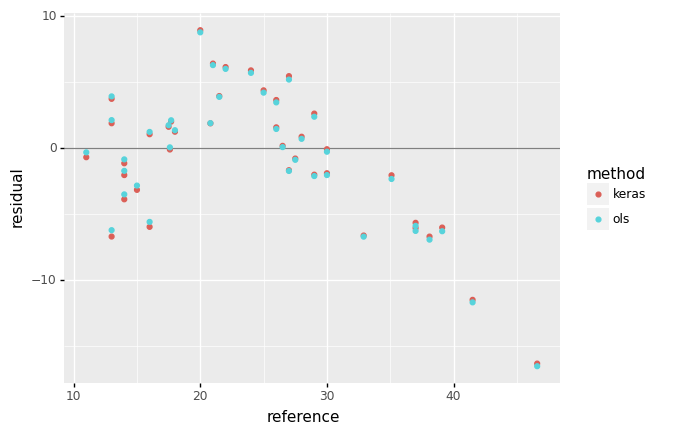

<ggplot: (8784261149163)>

In [158]:
from plotnine import *

prediction_results = pd.DataFrame({'keras'     : keras_mpg_weight.predict(test_data['Weight_norm']).flatten(),
                                   'ols'       : ols_mpg_weight.predict(test_data['Weight_norm']),
                                   'reference' : test_data['MPG']})

plot_data = (
    prediction_results
      .melt(id_vars='reference', var_name='method')
      .assign(residual = lambda x: x['value'] - x['reference'])
)

gg = (
    ggplot(plot_data) 
      + geom_hline(aes(yintercept = 0), alpha = 0.5)
      + geom_point(aes(x='reference', y='residual', color='method')) 
)

ggsave(gg, 'residualplot.png', dpi=200)
gg

# Forced polynomial regression: quadratic
https://medium.com/analytics-vidhya/polynomial-regression-with-keras-ef1797b39b88

In [160]:
from sklearn.preprocessing import PolynomialFeatures

def create_poly_features(series, n):
    poly = PolynomialFeatures(n)
    return poly.fit_transform(np.expand_dims(series, axis=1))

In [161]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense

n = 2  # Use quadratic polynomial regression
keras_mpg_weight_poly = keras.Sequential([ 
    Input(shape=(n+1,)), 
    Dense(units=1)
])

keras_mpg_weight_poly.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mean_squared_error')

history = keras_mpg_weight_poly.fit(
    create_poly_features(train_data['Weight_norm'], n), train_data['MPG'],
    epochs=100, verbose=0, validation_split = 0.2)

keras_mpg_weight_poly.get_weights()

[array([[11.092891 ],
        [-7.175882 ],
        [ 1.1208423]], dtype=float32),
 array([11.237832], dtype=float32)]

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: points_and_lines.png


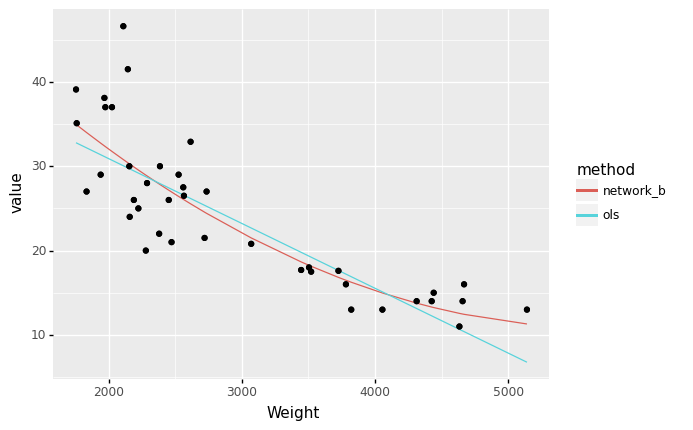

<ggplot: (8784227398259)>

In [164]:
prediction_results = pd.DataFrame({'network_b' : keras_mpg_weight_poly.predict(create_poly_features(test_data['Weight_norm'], n)).flatten(),
                                   'ols'       : ols_mpg_weight.predict(test_data['Weight_norm']),
                                   'reference' : test_data['MPG'], 
                                   'Weight'    : test_data['Weight']})

plt_data = prediction_results.sort_values('Weight').melt(id_vars=['reference', 'Weight'], var_name='method')
gg = (
    ggplot(plt_data, aes(x='Weight')) 
      + geom_path(aes(y='value', color='method'))
      + geom_point(aes(y='reference'))
)
ggsave(gg, 'points_and_lines.png', dpi=200)
gg

# Emergent solutions

In [165]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense

n = 2  # Use quadratic polynomial regression
keras_mpg_weight_2layers = keras.Sequential([ 
    Input(shape=(1,)), 
    Dense(units=n+1, activation='relu'),   
    Dense(units=1)
])

keras_mpg_weight_2layers.compile(
    optimizer=Adam(learning_rate=0.1),
    loss='mean_squared_error')

history = keras_mpg_weight_2layers.fit(
    train_data['Weight_norm'], train_data['MPG'],
    epochs=100, verbose=0, validation_split = 0.2)

#keras_mpg_weight_2layers.get_weights()

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: three_methods.png


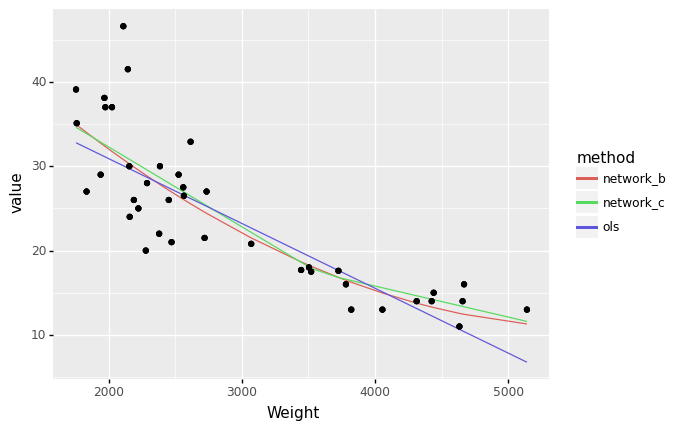

<ggplot: (8784260956432)>

In [169]:
prediction_results = pd.DataFrame({'network_b' : keras_mpg_weight_poly.predict(create_poly_features(test_data['Weight_norm'], n)).flatten(),
                                   'network_c' : keras_mpg_weight_2layers.predict(test_data['Weight_norm']).flatten(),
                                   'ols'       : ols_mpg_weight.predict(test_data['Weight_norm']),
                                   'reference' : test_data['MPG'], 
                                   'Weight'    : test_data['Weight']})

plt_data = prediction_results.sort_values('Weight').melt(id_vars=['reference', 'Weight'], var_name='method')
gg = (
    ggplot(plt_data, aes(x='Weight')) 
      + geom_path(aes(y='value', color='method'))
      + geom_point(aes(y='reference'))
)
ggsave(gg, 'three_methods.png', dpi=200)
gg